# Image compression for acoustic transmissions.

In [ ]:
__author__ = 'andrea munafo'

This notebook investigates some image compression methods using neural networks.

The point is to obtain a dimentionality reduction that can be supported over very bandwidth constrained media, such as acoustics.

This description of autoencoders is based on [Understanding Variational Autoencoders](
https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73), on [Autoencoding Variational Bayes](https://arxiv.org/pdf/1312.6114.pdf) and on [Tutorial on variational autoencoders](https://arxiv.org/abs/1606.05908).

and is reported here to provide a description for the implementation reported below.

All implementations are applied to the MNIST dataset.

## What is dimentionality reduction?

Dimensionality reduction is the process of reducing the number of features that describe some data.


This reduction can be done, either selecting specific features or by reducing to a new set of features created from the original ones (feature extraction).
Applications range from data visualisation, data storage, heavy computation and communications.

First, let’s call encoder the process that produce the “new features” representation from the “old features” representation (by selection or by extraction) and decoder the reverse process. 

Dimensionality reduction can then be interpreted as data compression where the encoder compress the data (from the initial space to the encoded space, also called latent space) whereas the decoder decompress them.
Of course, depending on the initial data distribution, the latent space dimension and the encoder definition, this compression can be lossy, meaning that a part of the information is lost during the encoding process and cannot be recovered when decoding.

![encoding-decoding](./pics/encoding-decoding.png)

The problem can be formulated as finding the optimal encoder $e$ in the set of possible encoders $E$, and the optimal decoder $d$, in the set of possible dencoders $D$, such that:

$(e*,d*) = argmin f(x, d(e(x))$
       
where $e \in E$, $d \in D$, and $f(.)$ is the function that defines the reconstruction error measure between the input data $x$ and the encoded-decoded data $d(e(x))$.

One way to solve this problem is using Principal Components Analysis (PCA).

The idea of PCA is to build $n_e$ new features that are linear combinations of the $n_d$ original features.
This is done so that the projections of the original data on the subspace defined by these new features are as close as possible to the initial data (in term of euclidean distance).
This is shown in the figure below:

![pca](./pics/pca-ex.png)

For example, the encoded version of point B is obtained as the projection of B onto the line that minimises the distance from all the points.

It can be shown that, the unitary eigenvectors corresponding to the $n_e$ greatest eigenvalues (in norm) of the covariance features matrix C are orthogonal (or can be chosen to be so) and define the best subspace of dimension $n_e$ to project data on with minimal error of approximation. 
These $n_e$ eigenvectors can then be chosen as the new features.
In the PCA context, the problem of dimension reduction can be expressed as an eigenvalue/eigenvector problem. 
Moreover, it can also be shown that the decoder matrix is the transposed of the encoder matrix.


Encoding and decoding matrices obtained with PCA define one of the solutions. 
However, several basis can be chosen to describe the same optimal subspace and, so, several encoder/decoder pairs can give the optimal reconstruction error.

Now, let’s assume that both the encoder and the decoder are deep and non-linear. In such case, the more complex the architecture is, the more the autoencoder can proceed to a high dimensionality reduction while keeping reconstruction loss low. Intuitively, if our encoder and our decoder have enough degrees of freedom, we can reduce any initial dimensionality to 1. Indeed, an encoder with “infinite power” could theoretically takes our N initial data points and encodes them as 1, 2, 3, … up to N (or more generally, as N integer on the real axis) and the associated decoder could make the reverse transformation, with no loss during the process.

Here, we should however keep two things in mind. First, an important dimensionality reduction with no reconstruction loss often comes with a price: the lack of interpretable and exploitable structures in the latent space (lack of regularity). Second, most of the time the final purpose of dimensionality reduction is not to only reduce the number of dimensions of the data but to reduce this number of dimensions while keeping the major part of the data structure information in the reduced representations. For these two reasons, the dimension of the latent space and the “depth” of autoencoders (that define degree and quality of compression) have to be carefully controlled and adjusted depending on the final purpose of the dimensionality reduction.

The concept is shown in the picture below. We would like to reduce the dimentionality, while keeping some of the structure of the data.

![pca](./pics/encoding.png)

# Autoencoders

In [1]:
import os

import pylab as plt
import numpy as np

import torch
import torchvision
from torch import nn
from torch.autograd import Variable
from torch.utils.data import DataLoader
from torchvision import transforms
from torchvision.datasets import MNIST
from torchvision.utils import save_image

In [2]:
print(torch.__version__)

1.3.0


In [3]:
import pathlib

pathlib.Path("../results/01-autoencoder/ae").mkdir(parents=True, exist_ok=True)
pathlib.Path("../results/01-autoencoder/convae").mkdir(parents=True, exist_ok=True)
pathlib.Path("../results/01-autoencoder/vae").mkdir(parents=True, exist_ok=True)
pathlib.Path("../saved-mdls/01-autoencoder").mkdir(parents=True, exist_ok=True)

In [4]:
num_epochs = 100
batch_size = 64
learning_rate = 1e-3

device = 'cuda'

In [5]:
def toImg(x, mu=0.5, std=1):
    """Converts x to an image shape. It works for batches of inputs."""
    x = mu * (x + std)
    x = x.clamp(0, 1)
    x = x.view(x.size(0), 1, 28, 28)
    return x

## Get the data

### Define some transforms to normalise the images 

In [6]:
ds_mean = 0.1307
ds_std = 0.3081

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((ds_mean,), (ds_std,)) # The first tuple (0.5, 0.5, 0.5) is the mean for all three channels and the second (0.5, 0.5, 0.5) is the standard deviation for all three channels.
])

### Grab the dataset

In [7]:
train_ds = MNIST('./data', train=True, transform=img_transform, download=True)
valid_ds = MNIST('./data', train=False, transform=img_transform, download=True)

100.1%

Extracting ./data/MNIST/raw/train-images-idx3-ubyte.gz to ./data/MNIST/raw


113.5%

Extracting ./data/MNIST/raw/train-labels-idx1-ubyte.gz to ./data/MNIST/raw


100.4%

Extracting ./data/MNIST/raw/t10k-images-idx3-ubyte.gz to ./data/MNIST/raw


180.4%

Extracting ./data/MNIST/raw/t10k-labels-idx1-ubyte.gz to ./data/MNIST/raw
Processing...
Done!


In [10]:
# plt.imshow(train_ds.data[1])

In [11]:
train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

## Define the model 

Defining an Autoencoder model is not difficult. The following class shows one potential option as a combination of Linear and ReLU layers.

In [12]:
class Autoencoder(nn.Module):
    def __init__(self):
        super(Autoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Linear(28 * 28, 128),
            nn.ReLU(True),
            nn.Linear(128, 64),
            nn.ReLU(True), 
            nn.Linear(64, 12), 
            nn.ReLU(True), 
            nn.Linear(12, 3))        
        
        self.decoder = nn.Sequential(
            nn.Linear(3, 12),
            nn.ReLU(True),
            nn.Linear(12, 64),
            nn.ReLU(True),
            nn.Linear(64, 128),
            nn.ReLU(True), 
            nn.Linear(128, 28 * 28), 
            nn.Tanh())

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, x):
        x = self.decoder(x)
        return x



## Train the model

In [13]:
model = Autoencoder()

In [14]:
loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

In [15]:
if device == 'cuda':
    model.cuda()

In [17]:
for epoch in range(num_epochs):
    for x, y in train_dl:
        x = x.view(x.size(0), -1).to(device)  # resize to be a vector bsx28*28
#        x = Variable(x).cuda()         

        output = model(x)
        loss = loss_fn(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data))
    
    if epoch % 10 == 0:
        ipic = toImg(x.cpu().data)
        opic = toImg(output.cpu().data)

        save_image(opic, '../results/ae/image_{}_o.png'.format(epoch))
        save_image(ipic, '../results/ae/image_{}_i.png'.format(epoch))

epoch [1/100], loss:0.5602
epoch [2/100], loss:0.5473
epoch [3/100], loss:0.5371
epoch [4/100], loss:0.5408
epoch [5/100], loss:0.4876
epoch [6/100], loss:0.4854
epoch [7/100], loss:0.4918
epoch [8/100], loss:0.5050
epoch [9/100], loss:0.5683
epoch [10/100], loss:0.4808
epoch [11/100], loss:0.4911
epoch [12/100], loss:0.4622
epoch [13/100], loss:0.5145
epoch [14/100], loss:0.5030
epoch [15/100], loss:0.4437
epoch [16/100], loss:0.5159
epoch [17/100], loss:0.5257
epoch [18/100], loss:0.4939
epoch [19/100], loss:0.4832
epoch [20/100], loss:0.4450
epoch [21/100], loss:0.4416
epoch [22/100], loss:0.4433
epoch [23/100], loss:0.4908
epoch [24/100], loss:0.4583
epoch [25/100], loss:0.4830
epoch [26/100], loss:0.4803
epoch [27/100], loss:0.4719
epoch [28/100], loss:0.4317
epoch [29/100], loss:0.4332
epoch [30/100], loss:0.5100
epoch [31/100], loss:0.4836
epoch [32/100], loss:0.4686
epoch [33/100], loss:0.4797
epoch [34/100], loss:0.5120
epoch [35/100], loss:0.4823
epoch [36/100], loss:0.4763
e

We are now done training. We can save the model so that we can use it later on.

In [18]:
# As suggested in https://pytorch.org/tutorials/beginner/saving_loading_models.html
torch.save(model, '../saved-mdls/01-autoencoder/autoencoder_{}e.pt'.format(epoch+1))

/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type Autoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


# Using and validating the simple autoencoder 

In [ ]:
# Model class must be defined somewhere
model = torch.load('../saved-mdls/01-autoencoder/autoencoder.pt')
model.eval()

In [ ]:
for count, (x, _) in enumerate(valid_dl):
    x = x.view(x.size(0), -1)
    encoding = model.encode(x)
    decoding = model.decode(encoding)
    
    # save (some) results
    if count % 10 == 0:
        ipic = to_img(x.cpu().data)    
        opic = to_img(decoding.cpu().data)
        save_image(ipic, '../results/01-autoencoder/ae/val-{}-enc.png'.format(count))
        save_image(opic, '../results/01-autoencoder/ae/val-{}-dec.png'.format(count))

Let's see how each image was encoded.  
The next line prints the encodings for the last batch.

In [ ]:
print('encoded output: {}'.format(encoding.detach().cpu().numpy()))

If we want to analyse the results inline we can grab the encoding/decoding variables and play with them.

In [29]:
idx = 0

In [ ]:
plt.imshow(decoding[idx].cpu().data.view(28, 28))

In [ ]:
f, axarr = plt.subplots(1,2)
axarr[0].imshow(x[idx].cpu().data.view(28,28))
axarr[1].imshow(decoding[idx].cpu().data.view(28, 28))

## Encoding / Decoding single images

To do this, I am going to use the validation set again, but one can do the same with any image.

In [19]:
model.eval()

Autoencoder(
  (encoder): Sequential(
    (0): Linear(in_features=784, out_features=128, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=128, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=12, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=12, out_features=3, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=3, out_features=12, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=12, out_features=64, bias=True)
    (3): ReLU(inplace)
    (4): Linear(in_features=64, out_features=128, bias=True)
    (5): ReLU(inplace)
    (6): Linear(in_features=128, out_features=784, bias=True)
    (7): Tanh()
  )
)

In [23]:
idx = 1001 # select an index in the validation set

In [24]:
# Define the transforms to normalise the image
pic_tt = transforms.ToTensor() # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
pic_n = transforms.Normalize((ds_mean,), (ds_std,))

if torch.__version__ != '1.3.0':
    pic_data = valid_ds.test_data[idx].numpy()
    pic_data = pic_data[:, :, None] # (H x W x C)
    print('pic_data.dtype: {}'.format(pic_data.dtype))
else:
    pic_data = valid_ds.data[idx].numpy()
    
pic = pic_tt(pic_data)
pic = pic_n(pic)

# print stats
print('pic mean: {}, std: {}'.format(pic.mean(), pic.std()))

# print pic shape
print('\npic shape (C x H x W): {}'.format(pic.shape))

pic_data.dtype: uint8
pic mean: 0.02145381271839142, std: 1.0174704790115356

pic shape (C x H x W): torch.Size([1, 28, 28])


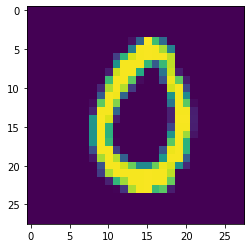

In [25]:
plt.imshow(pic.view(28,28))

### Run the model to encode

In [26]:
encoding = model.encode(pic.to(device).view(1, -1)) # note that we need to reshape the pic to be: bsx28*28 

# print encoding result
print('encoded output: {}'.format(encoding.detach().cpu().numpy()))

encoded output: [[-9.222232   9.739955  -7.7938967]]


### Run the decoder and show the result

In [27]:
decoding = model.decode(encoding)

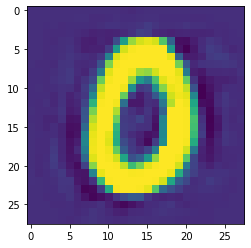

In [28]:
plt.imshow(decoding.cpu().data.view(28, 28))

## Generating new images

In [ ]:
encoding = torch.tensor([
    [17., -10., +0.]])

decoding = model.decode(encoding)
plt.imshow(decoding.cpu().data.view(28, 28))

# Convolutional Autoencoders 

Alternatively, one can define a Convolutional Autoencoder, where the network is composed of a sequence of convolutional layers.

In [33]:
class ConvAutoencoder(nn.Module):
    def __init__(self):
        super(ConvAutoencoder, self).__init__()
        self.encoder = nn.Sequential(
            nn.Conv2d(1, 16, 3, stride=3, padding=1),  # b, 16, 10, 10
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=2),  # b, 16, 5, 5
            nn.Conv2d(16, 8, 3, stride=2, padding=1),  # b, 8, 3, 3
            nn.ReLU(True),
            nn.MaxPool2d(2, stride=1)  # b, 8, 2, 2
        )
        self.decoder = nn.Sequential(
            nn.ConvTranspose2d(8, 16, 3, stride=2),  # b, 16, 5, 5
            nn.ReLU(True),
            nn.ConvTranspose2d(16, 8, 5, stride=3, padding=1),  # b, 8, 15, 15
            nn.ReLU(True),
            nn.ConvTranspose2d(8, 1, 2, stride=2, padding=1),  # b, 1, 28, 28
            nn.Tanh()
        )

    def forward(self, x):
        x = self.encoder(x)
        x = self.decoder(x)
        return x
        
    def encode(self, x):
        x = self.encoder(x)
        return x
    
    def decode(self, x):
        x = self.decoder(x)
        return x

In [35]:
model = ConvAutoencoder()

loss_fn = nn.MSELoss()
optimizer = torch.optim.Adam(model.parameters(), lr=learning_rate, weight_decay=1e-5)

if device == 'cuda': model.cuda()

for epoch in range(num_epochs):
    for x, y in train_dl:
        x = x.to(device)  # resize to be a vector bsx28*28

        output = model(x)
        loss = loss_fn(output, x)
        
        optimizer.zero_grad()
        loss.backward()
        optimizer.step()
        
    print('epoch [{}/{}], loss:{:.4f}'.format(epoch + 1, num_epochs, loss.data))
    
    if epoch % 10 == 0:
        ipic = toImg(x.cpu().data)
        opic = toImg(output.cpu().data)

        save_image(opic, '../results/01-autoencoder/convae/image_{}_conv_o.png'.format(epoch))
        save_image(ipic, '../results/01-autoencoder/convae/image_{}_conv_i.png'.format(epoch))

epoch [1/100], loss:0.5109
epoch [2/100], loss:0.4628
epoch [3/100], loss:0.5199
epoch [4/100], loss:0.4988
epoch [5/100], loss:0.4752
epoch [6/100], loss:0.4783
epoch [7/100], loss:0.4565
epoch [8/100], loss:0.4774
epoch [9/100], loss:0.4367
epoch [10/100], loss:0.5051
epoch [11/100], loss:0.4323
epoch [12/100], loss:0.4938
epoch [13/100], loss:0.4625
epoch [14/100], loss:0.4442
epoch [15/100], loss:0.4359
epoch [16/100], loss:0.4216
epoch [17/100], loss:0.4128
epoch [18/100], loss:0.5216
epoch [19/100], loss:0.4163
epoch [20/100], loss:0.4229
epoch [21/100], loss:0.4854
epoch [22/100], loss:0.4435
epoch [23/100], loss:0.4405
epoch [24/100], loss:0.3971
epoch [25/100], loss:0.4503
epoch [26/100], loss:0.4532
epoch [27/100], loss:0.4384
epoch [28/100], loss:0.4189
epoch [29/100], loss:0.4507
epoch [30/100], loss:0.4159
epoch [31/100], loss:0.4487
epoch [32/100], loss:0.4177
epoch [33/100], loss:0.4478
epoch [34/100], loss:0.4493
epoch [35/100], loss:0.4836
epoch [36/100], loss:0.4739
e

In [38]:
# As suggested in https://pytorch.org/tutorials/beginner/saving_loading_models.html
filename = '../saved-mdls/01-autoencoder/convautoencoder_{}e.pt'.format(epoch+1)
torch.save(model, filename)

print('model saved as: {}'.format(filename))

model saved as: ./saved-mdls/01-autoencoder/convautoencoder_100e.pt


/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type ConvAutoencoder. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


In [39]:
model.eval()

ConvAutoencoder(
  (encoder): Sequential(
    (0): Conv2d(1, 16, kernel_size=(3, 3), stride=(3, 3), padding=(1, 1))
    (1): ReLU(inplace)
    (2): MaxPool2d(kernel_size=2, stride=2, padding=0, dilation=1, ceil_mode=False)
    (3): Conv2d(16, 8, kernel_size=(3, 3), stride=(2, 2), padding=(1, 1))
    (4): ReLU(inplace)
    (5): MaxPool2d(kernel_size=2, stride=1, padding=0, dilation=1, ceil_mode=False)
  )
  (decoder): Sequential(
    (0): ConvTranspose2d(8, 16, kernel_size=(3, 3), stride=(2, 2))
    (1): ReLU(inplace)
    (2): ConvTranspose2d(16, 8, kernel_size=(5, 5), stride=(3, 3), padding=(1, 1))
    (3): ReLU(inplace)
    (4): ConvTranspose2d(8, 1, kernel_size=(2, 2), stride=(2, 2), padding=(1, 1))
    (5): Tanh()
  )
)

In [40]:
idx = 1001 # select an index in the validation set

In [41]:
# Define the transforms to normalise the image
pic_tt = transforms.ToTensor() # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
pic_n = transforms.Normalize((ds_mean,), (ds_std,))

if torch.__version__ != '1.3.0':
    pic_data = valid_ds.test_data[idx].numpy()
    pic_data = pic_data[:, :, None] # (H x W x C)
    print('pic_data.dtype: {}'.format(pic_data.dtype))
else:
    pic_data = valid_ds.data[idx].numpy()
    
pic = pic_tt(pic_data)
pic = pic_n(pic)

# print stats
print('pic mean: {}, std: {}'.format(pic.mean(), pic.std()))

# print pic shape
print('\npic shape (C x H x W): {}'.format(pic.shape))

pic_data.dtype: uint8
pic mean: 0.02145381271839142, std: 1.0174704790115356

pic shape (C x H x W): torch.Size([1, 28, 28])


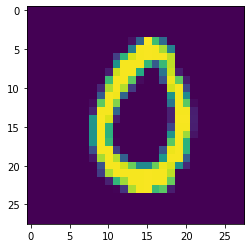

In [42]:
plt.imshow(pic.view(28,28))

### Run the model to encode

In [47]:
print(pic.to(device)[None, :, :, :].shape)

torch.Size([1, 1, 28, 28])


In [48]:
encoding = model.encode(pic.to(device)[None, :, :, :]) # note that we need to reshape the pic to be: bsx28*28 

# print encoding result
print('encoded output: {}'.format(encoding.detach().cpu().numpy()))

encoded output: [[[[10.795247    6.077096  ]
   [ 5.69029     0.        ]]

  [[ 2.3519301   2.3519301 ]
   [ 2.3519301   2.3519301 ]]

  [[ 6.9652967   6.9652967 ]
   [ 0.5121887   0.5121887 ]]

  [[ 1.8640186   7.8633065 ]
   [ 5.015077    9.722703  ]]

  [[ 0.46509135  0.46509135]
   [ 8.607014    8.607014  ]]

  [[ 9.282421    5.930196  ]
   [ 4.88288     1.791863  ]]

  [[ 0.          7.888112  ]
   [ 1.9434392   6.8836126 ]]

  [[12.865752   12.865752  ]
   [12.865752   12.865752  ]]]]


### Run the decoder and show the result

In [49]:
decoding = model.decode(encoding)

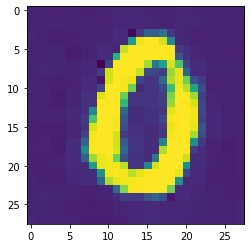

In [50]:
plt.imshow(decoding.cpu().data.view(28, 28))

# Variational Autoencoders

We have discussed the problem of dimentionality reduction, and used encoder-decoder architectures to address it.

At this point, one question might arise: what is the link between autoencoders and content generation?

we could be tempted to think that, if the latent space is regular enough (well “organized” by the encoder during the training process), we could take a point randomly from that latent space and decode it to get a new content. The decoder would then act more or less like the generator of a Generative Adversarial Network.

As done before, we can generate new data by decoding points that are randomly sampled from the latent space. The quality and relevance of generated data depend on the regularity of the latent space.

The problem is that the regularity of the latent space for autoencoders depends on the distribution of the data in the initial space, the dimension of the latent space and the architecture of the encoder. 
It is difficult to ensure that the encoder will organize the latent space in a smart way compatible with the generative process we just described.


This lack of structure among the encoded data into the latent space is normal since during training we never enforced such organization of the latern space.
We only trained to encode and decode so that we can minimize the loss.


To use the decoder of our autoencoder for generative purpose, we have to be sure that the latent space is regular enough. One possible solution to obtain such regularity is to introduce explicit regularisation during the training process. 

A variational autoencoder is an autoencoder whose training is regularised to avoid overfitting and ensure that the latent space has good properties that enable generative process.

Just as a standard autoencoder, a variational autoencoder is an architecture composed of both an encoder and a decoder and that is trained to minimise the reconstruction error between the encoded-decoded data and the initial data. However, in order to introduce some regularisation of the latent space, we proceed to a slight modification of the encoding-decoding process: instead of encoding an input as a single point, we encode it as a distribution over the latent space. 

To do this, the loss function that is minimised when training a VAE is composed of a “reconstruction term” (on the final layer), that tends to make the encoding-decoding scheme as performant as possible, and a “regularisation term” (on the latent layer), that tends to regularise the organisation of the latent space by making the distributions returned by the encoder close to a standard normal distribution. 

One way to measure the difference between probability distribution is using the Kullback-Leibler divergence.

In practice, the encoded distributions are chosen to be normal so that the encoder can be trained to return the mean and the covariance matrix that describe these Gaussians. 
The reason why an input is encoded as a distribution with some variance instead of a single point is that it makes possible to express very naturally the latent space regularisation: the distributions returned by the encoder are enforced to be close to a standard normal distribution. 
Moreover, the Kullback-Leibler divergence between two Gaussian distributions has a closed form that can be directly expressed in terms of the means and the covariance matrices of the two distributions.

## Intuition

The regularity that is expected from the latent space in order to make generative process possible can be expressed through two main properties: 
- continuity (two close points in the latent space should not give two completely different contents once decoded)
- completeness (for a chosen distribution, a point sampled from the latent space should give “meaningful” content once decoded)

A point of the latent space that would be halfway between the means of two encoded distributions coming from different training data should be decoded in something that is somewhere between the data that gave the first distribution and the data that gave the second distribution as it may be sampled by the autoencoder in both cases.

## Probabilistic framework

Variational autoencoders encode inputs as distributions (e.g. mean and std) and not as simple points (or vectors). The regularisation of the latent space is obtained constraining the distribution to be as close as possible to a Gaussian.

$x$ : data  
$z$ : encoded rapresentation of $x$

We also assume that $z$ cannot be directly observed. Hewover, the latent representation $z$ can be sampled from the prior distribution $p(z)$

The data $x$ can be sampled from the conditional likelihood distribution: $p(x|z)$.

Within this framework, we can consider the probabilistic versions of encoders and decoders (instead of the deterministic ones that we described before).

- The “probabilistic decoder” is defined by $p(x|z)$, that describes the distribution of the decoded variable given the encoded one.

- The “probabilistic encoder” is defined by $p(z|x)$, that describes the distribution of the encoded variable given the decoded one.

Where of course, the link between the two is obtained through the Bayes' theorem: $p(z|x) = p(x|z)p(z)/p(x)$.

The previous equation also means that the encoder $p(z|x)$ depends on the prior $p(z)$, or on the encoded representation of $z$ in the latent space.

Let's assume:

$p(z) = \mathcal{N}(0, I)$  
$p(x|z) = \mathcal{N}(f(z), cI)$, where $f \in F$ (family of functions), and $I$ is the identity matrix, $c$ constant > 0

If we consider $f$ to be well defined, fixed (and known), and if we know $p(x)$, can have all the elements to solve this problem and calculate $p(z|x)$. However calculating $p(x)$ is often intractable as $p(x)=\int p(x|u)p(u)du$

### Variational inference

Variational inference (VI) can be used to approximate complex distributions and hence we can use it to approximate $p(z|x)$.

The idea is to set a parametrised family of distribution (for example the family of Gaussians, whose parameters are the mean and the covariance) and to look for the best approximation of the target distribution among this family.

The best element in the family is one that minimise a given approximation error measurement (most of the time the Kullback-Leibler divergence between approximation and target).

This can be done using gradient descent over the parameters that describe the family [REF].

To do so, we assume $p(z|x)$, our target distribution as a Gaussian:

$p(z|x) = \mathcal{N}(g(x), h(x))$,

This means that we have chosen a Gaussian to approximate $p(z|x)$, whose mean and covariance are defined by two functions, $g$ and $h$, of the parameter $x$ (the data).

The problem than become that of finding the best approximation among this family by optimising the functions g and h (or better, their parameters) to minimise the Kullback-Leibler (KL) divergence between the approximation $\mathcal{N}(g(x), h(x))$ and the target $p(z|x)$, or:

\begin{equation*}
(g^*, h^*) = arg \min_{g,h} KL(\mathcal{N}(g(x), h(x)), p(z|x)).
\label{eq:optimal-encoder} \tag{1}
\end{equation*}

This would give us the optimal encoder $p^*(z|x) = \mathcal{N}(g^*(x), h^*(x))$.

Eq. (1), with a little bit of work (see [Understanding Variational Autoencoders](
https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)) can be written as:


\begin{equation*}
(g^*, h^*) = \underset{g,h\in (GxH)}{\operatorname{argmax}} \{
\mathbb{E}_{z \sim \mathcal{N}(g(x), h(x))} [  log(p(x|z) ] - KL( \mathcal{N}(g(x), h(x)), p(z)) \}
\label{eq:optimal-encoder-2} \tag{2}
\end{equation*}

### Comment
All this reasoning was based on the assumption that we know $f(z)$. In fact, given that we know $f(z)$, we can calculate $p(x|z)$ (the decoder) and then we calculate the encoder $p(z|x)$ approximating it via variational inference.

However, in practise, $f(z)$ is not known and need to be chosen. In fact, the objective is to find a couple encoder-decoder with a regularised latent space, and the decoder $p(x|z)$ is a function of the function $f(z)$.

We have also realised that the encoder $p(z|x)$ depends on the prior $p(z)$ (Bayes' theorem).

As $p(z|x)$ can be approximated (by variational inference) from $p(z)$, and given that $p(x|z)$ and $p(z)$ have been set to be simple standard Gaussian, 
we only have two parameters in our model: $c$ (that defines the variance of the posterior, $p(x|z)$) and the function $f$ (that defines the mean of the posterior).

In short:
- the encoder-decoder performance depends on the function $f(z)$
- the regularity of the latent space depends on the prior $p(z)$

This makes sense intuitively, as $f(z)$ defines the encoder, and $p(z)$ defines the latent space distribution.

## The encoder 

Different functions $f(z)$ define different encoders.

We would like to find the best $f$ that maximise the encoding/decoding performance, or:

We want to choose the function $f$ that maximises the expected log-likelihood of $x$ (the data) given $z$ (its latent representation or encoding) when $z$ is sampled from $p^*(z|x)$. Where $p^*(z|x)$ is the optimal encoder, calculated as before.

For a given input $x$, we want to:
- maximise the probability to have $\hat x = x$
- when we sample $z$ from the distribution $p^*(z|x)$ (encoding)
- and then sample $\hat x$ from the distribution $p(x|z)$ (decoding).

We can write this as:

\begin{equation}
f^* = \underset{f\in F}{\operatorname{argmax}}
\mathbb{E}_{z \sim p^*(z|x)} [ \log p(x|z) ] 
\label{eq:optimal-decoder} \tag{3}
\end{equation}

Note that, if $p(x|z) = \mathcal{N}(f(z), cI)$, then
$\log p(x|z) = - \frac{||x-f(z)||^2}{2c}$


## Encoder/Decoder

If we now put everything together (Eq.(1), (2), (3)):

\begin{equation*}
(f^*, g^*, h^*) = \underset{f,g,h\in (FxGxH)}{\operatorname{argmax}} \{
\mathbb{E}_{z \sim \mathcal{N}(g(x), h(x))} [  log(p(x|z) ] -  KL( \mathcal{N}(g(x), h(x)), p(z)) \}
\label{eq:optimal-encoder-2}
\end{equation*}

$\tag{4}$

with $\log p(x|z) = - \frac{||x-f(z)||^2}{2c}$

*Comments:*

The previous Eq (4), includes:
- the reconstruction error between $x$ and $f(z)$ (objective 1)
- the regularisation term given by the $KL$ divergence between $\mathcal{N}(g(x), h(x))$ and $p(z)$ (which is a standard Gaussian) (objective 2). 

The constant $c$ acts as the balance between these two objectives: 

The higher $c$ is, the more we assume a high variance around $f(z)$ for the probabilistic decoder in our model and, the more we favour the regularisation term over the reconstruction term.  
The opposite stands if $c$ is small.

## Implementing a variational encoder with neural nets

We can’t easily optimise over the entire space of functions.
One way to solve this problem is to constrain the optimisation domain and decide to express $f$, $g$ and $h$ as neural networks.  
In this case, $F$, $G$ and $H$ correspond respectively to the families of functions defined by the networks architectures and the optimisation is done over the parameters of these networks.

In practise, $g$ and $h$, which together define the encoder $p(z|x)$ are defined to share the initial part of their network architecture.  

![encoder-part-of-the-VAE](pics/encoder-part-of-the-VAE.png)
**Figure: Encoder part of the VAE (from [Understanding Variational Autoencoders](
https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73))**


Moreover, to simplify the problem, $\mathcal{N}(g(x), h(x))$ is assumed as a multidimensional Gaussian distribution with diagonal covariance matrix.

Under this assumption, the function $h(x)$ which defines the covariance matrix, is the vector of the diagonal elements.

To summarise, the output of the encoder part is a Gaussian with both mean $g$ and covariance $h$ that are functions of $x$.

The decoder network $f$ needs instead to model $p(x|z)$ that we defined as a Gaussian with unit variance.

As usual, the overall architecture is then obtained by concatenating the encoder and the decoder parts.

## Reparametrisation

The last element that remains is related to the fact that we need to sample from the encoded distribution $p(z|x)$ in a way that we can backpropagate the error through the network.

The reparametrisation allows us to do exactly that: makes the gradient descent possible despite the random sampling that occurs halfw aythrough the architecture.

The real trick is to understand that $z$ is a random variable sampled from a Gaussian distribution with mean $g(x)$ and variance $h(x)$.

This means that we can express $z$ as:

$z=h(x) \eta + g(x)$,

with $\eta \sim \mathcal{N}(0, I)$

In this way, we have sandboxed the sampling to only happen on the variable $\eta$, while we can do gradient descent over $h(x)$ and $g(x)$.

## Objective function 

Finally, the _objective function_ of the variational autoencoder is defined by Eq. (4), where the expectation operator is replaced, most of the time by a Monte-Carlo approximation (sometimes obtained as a single draw).

The final architecture is sketched out in the next figure (from [Understanding Variational Autoencoders](
https://towardsdatascience.com/understanding-variational-autoencoders-vaes-f70510919f73)):

![variational-autoencoder.png](pics/variational-autoencoder.png)

**Figure: architecture of a variational autoencoder (C = $\frac{1}{2c}$)**

# Implementing a variational autoencoder

## Grab the data 

In [11]:
num_epochs = 100
batch_size = 128
learning_rate = 1e-3



ds_mean = 0.1307
ds_std = 0.3081

img_transform = transforms.Compose([
    transforms.ToTensor(),
    transforms.Normalize((ds_mean,), (ds_std,)) # The first tuple (0.5, 0.5, 0.5) is the mean for all three channels and the second (0.5, 0.5, 0.5) is the standard deviation for all three channels.
])

### Grab the dataset

train_ds = MNIST('./data', train=True, transform=img_transform, download=True)
valid_ds = MNIST('./data', train=False, transform=img_transform, download=True)

# plt.imshow(train_ds.data[1])

train_dl = DataLoader(train_ds, batch_size=batch_size, shuffle=True)
valid_dl = DataLoader(valid_ds, batch_size=batch_size, shuffle=True)

## Define the model

In [5]:
class VAE(nn.Module):
    def __init__(self):
        super(VAE, self).__init__()

        self.base_encoder = nn.Sequential(
            nn.Linear(28 * 28, 400),
            nn.ReLU(True)
        )
            
        self.mean_encoder = nn.Sequential(
            self.base_encoder,
            nn.Linear(400, 20)
        )
        
        self.var_encoder = nn.Sequential(
            self.base_encoder,
            nn.Linear(400, 20)
        )
                
        self.decoder = nn.Sequential(
            nn.Linear(20, 400),
            nn.ReLU(True),
            nn.Linear(400, 784),
            nn.Sigmoid()
        )
                
    def forward(self, x):
        mu, logvar = self.mean_encoder(x), self.var_encoder(x)        
        z = self.reparametrize(mu, logvar)        
        return self.decoder(z), mu, logvar

    def encode(self, x):
        return self.mean_encoder(x), self.var_encoder(x)        
    
    def decode(self, x):
        mu, logvar = x[0], x[1]
        z = self.reparametrize(mu, logvar)        
        return self.decoder(z), mu, logvar
    
    def reparametrize(self, mu, logvar):
        """This function implements the reparametrisation trick:
        z = h(x)*eta+g(x), eta is Gaussian
        """
        std = logvar.mul(0.5).exp_()
                    
        # sample the normal distribution        
        if torch.cuda.is_available():
            eta = torch.cuda.FloatTensor(std.size()).normal_()
        else:
            eta = torch.FloatTensor(std.size()).normal_()                
            
        return eta.mul(std).add_(mu)



In [29]:
model = VAE()
optimizer = torch.optim.Adam(
    model.parameters(), lr=learning_rate, weight_decay=1e-5)

if torch.cuda.is_available():
    model.cuda()
    
model.train()

VAE(
  (base_encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU(inplace)
  )
  (mean_encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU(inplace)
    )
    (1): Linear(in_features=400, out_features=20, bias=True)
  )
  (var_encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU(inplace)
    )
    (1): Linear(in_features=400, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU(inplace)
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

In [30]:
mse = nn.MSELoss(size_average=False)
bce = nn.BCELoss(size_average=False)


def loss_f(x_hat, x, mu, logvar):
    """
    x_hat: generated img.
    x: origin img.
    mu: latent mean
    logvar: latent log variance (log(sigma^2))
    """
    
    # E[log P(x|z)]     
    approx_err = bce(x_hat, x)  # (-||x-f(z)||^2/(2c))
    
    # The divergence between two Gaussians can be calculated in closed form.
    # loss = 0.5 * sum(1 + log(sigma^2) - mu^2 - sigma^2)
    _kl = mu.pow(2).add_(logvar.exp()).mul_(-1).add_(1).add_(logvar)
    KL = torch.sum(_kl).mul_(-0.5)
            
    return approx_err + KL

## Train

In [31]:
model.train()
num_epochs = 100

for epoch in range(num_epochs):
    train_loss = 0
    for batch_idx, (x, y) in enumerate(train_dl):
        x = x.view(x.size(0), -1) # batchsize x 128
        
        if torch.cuda.is_available():
            x = x.cuda()
        
        y_hat, mu, logvar = model(x)
        
        loss = loss_f(y_hat, x, mu, logvar)
        
        optimizer.zero_grad()
        loss.backward()                        
        optimizer.step()
        
        train_loss += loss.data.item()        
        
        if batch_idx % 100 == 0:
            print('Train Epoch: {} [{}/{} ({:.0f}%)]\tLoss: {:.6f}'.format(
                epoch,
                batch_idx * len(x),
                len(train_dl.dataset), 100. * batch_idx / len(train_dl),
                loss.data.item() / len(x)))

    print('>>  Epoch: {} Average loss: {:.4f}'.format(
        epoch, train_loss / len(train_dl.dataset)))
    
    if epoch % 10 == 0:
        save_image(toImg(x.cpu().data), '../results/01-autoencoder/vae/image_{}_i.png'.format(epoch))       
        save_image(toImg(y_hat.cpu().data), '../results/01-autoencoder/vae/image_{}_o.png'.format(epoch))       

Train Epoch: 0 [0/60000 (0%)]	Loss: 548.798096
Train Epoch: 0 [12800/60000 (21%)]	Loss: -10400.995117
Train Epoch: 0 [25600/60000 (43%)]	Loss: -13520.972656
Train Epoch: 0 [38400/60000 (64%)]	Loss: -15273.527344
Train Epoch: 0 [51200/60000 (85%)]	Loss: -15952.123047
>>  Epoch: 0 Average loss: -12749.0210
Train Epoch: 1 [0/60000 (0%)]	Loss: -16029.354492
Train Epoch: 1 [12800/60000 (21%)]	Loss: -16067.035156
Train Epoch: 1 [25600/60000 (43%)]	Loss: -16273.087891
Train Epoch: 1 [38400/60000 (64%)]	Loss: -16572.113281
Train Epoch: 1 [51200/60000 (85%)]	Loss: -16374.041016
>>  Epoch: 1 Average loss: -16285.1504
Train Epoch: 2 [0/60000 (0%)]	Loss: -16515.455078
Train Epoch: 2 [12800/60000 (21%)]	Loss: -16544.494141
Train Epoch: 2 [25600/60000 (43%)]	Loss: -16339.613281
Train Epoch: 2 [38400/60000 (64%)]	Loss: -16133.729492
Train Epoch: 2 [51200/60000 (85%)]	Loss: -16039.532227
>>  Epoch: 2 Average loss: -16280.5579
Train Epoch: 3 [0/60000 (0%)]	Loss: -16026.655273
Train Epoch: 3 [12800/6000

Train Epoch: 26 [25600/60000 (43%)]	Loss: -15726.582031
Train Epoch: 26 [38400/60000 (64%)]	Loss: -15938.704102
Train Epoch: 26 [51200/60000 (85%)]	Loss: -15694.555664
>>  Epoch: 26 Average loss: -15808.7790
Train Epoch: 27 [0/60000 (0%)]	Loss: -15663.542969
Train Epoch: 27 [12800/60000 (21%)]	Loss: -15626.659180
Train Epoch: 27 [25600/60000 (43%)]	Loss: -16402.958984
Train Epoch: 27 [38400/60000 (64%)]	Loss: -15684.948242
Train Epoch: 27 [51200/60000 (85%)]	Loss: -15679.839844
>>  Epoch: 27 Average loss: -15828.3127
Train Epoch: 28 [0/60000 (0%)]	Loss: -15980.693359
Train Epoch: 28 [12800/60000 (21%)]	Loss: -15336.357422
Train Epoch: 28 [25600/60000 (43%)]	Loss: -15683.900391
Train Epoch: 28 [38400/60000 (64%)]	Loss: -15997.925781
Train Epoch: 28 [51200/60000 (85%)]	Loss: -16086.597656
>>  Epoch: 28 Average loss: -15855.4075
Train Epoch: 29 [0/60000 (0%)]	Loss: -15888.863281
Train Epoch: 29 [12800/60000 (21%)]	Loss: -15684.571289
Train Epoch: 29 [25600/60000 (43%)]	Loss: -15961.804688

Train Epoch: 52 [38400/60000 (64%)]	Loss: -16948.828125
Train Epoch: 52 [51200/60000 (85%)]	Loss: -17177.294922
>>  Epoch: 52 Average loss: -17001.3476
Train Epoch: 53 [0/60000 (0%)]	Loss: -16871.671875
Train Epoch: 53 [12800/60000 (21%)]	Loss: -16856.982422
Train Epoch: 53 [25600/60000 (43%)]	Loss: -16822.964844
Train Epoch: 53 [38400/60000 (64%)]	Loss: -16449.992188
Train Epoch: 53 [51200/60000 (85%)]	Loss: -17396.875000
>>  Epoch: 53 Average loss: -16953.9299
Train Epoch: 54 [0/60000 (0%)]	Loss: -17157.412109
Train Epoch: 54 [12800/60000 (21%)]	Loss: -16841.775391
Train Epoch: 54 [25600/60000 (43%)]	Loss: -16886.615234
Train Epoch: 54 [38400/60000 (64%)]	Loss: -16942.320312
Train Epoch: 54 [51200/60000 (85%)]	Loss: -16818.152344
>>  Epoch: 54 Average loss: -16996.4448
Train Epoch: 55 [0/60000 (0%)]	Loss: -16912.093750
Train Epoch: 55 [12800/60000 (21%)]	Loss: -16525.378906
Train Epoch: 55 [25600/60000 (43%)]	Loss: -17093.421875
Train Epoch: 55 [38400/60000 (64%)]	Loss: -17006.072266

Train Epoch: 78 [51200/60000 (85%)]	Loss: -16567.976562
>>  Epoch: 78 Average loss: -16514.9580
Train Epoch: 79 [0/60000 (0%)]	Loss: -16274.107422
Train Epoch: 79 [12800/60000 (21%)]	Loss: -15965.790039
Train Epoch: 79 [25600/60000 (43%)]	Loss: -16976.404297
Train Epoch: 79 [38400/60000 (64%)]	Loss: -16533.996094
Train Epoch: 79 [51200/60000 (85%)]	Loss: -16301.074219
>>  Epoch: 79 Average loss: -16574.6297
Train Epoch: 80 [0/60000 (0%)]	Loss: -16861.246094
Train Epoch: 80 [12800/60000 (21%)]	Loss: -16715.041016
Train Epoch: 80 [25600/60000 (43%)]	Loss: -16621.761719
Train Epoch: 80 [38400/60000 (64%)]	Loss: -16638.947266
Train Epoch: 80 [51200/60000 (85%)]	Loss: -16915.890625
>>  Epoch: 80 Average loss: -16756.9602
Train Epoch: 81 [0/60000 (0%)]	Loss: -17538.429688
Train Epoch: 81 [12800/60000 (21%)]	Loss: -17190.730469
Train Epoch: 81 [25600/60000 (43%)]	Loss: -17047.847656
Train Epoch: 81 [38400/60000 (64%)]	Loss: -16756.128906
Train Epoch: 81 [51200/60000 (85%)]	Loss: -16829.742188

In [32]:
# As suggested in https://pytorch.org/tutorials/beginner/saving_loading_models.html
filename = '../saved-mdls/01-autoencoder/vae_{}e.pt'.format(epoch+1)
torch.save(model, filename)

print('model saved as: {}'.format(filename))

model saved as: ./saved-mdls/01-autoencoder/vae_100e.pt


/opt/anaconda3/lib/python3.7/site-packages/torch/serialization.py:256: UserWarning: Couldn't retrieve source code for container of type VAE. It won't be checked for correctness upon loading.
  "type " + obj.__name__ + ". It won't be checked "


## Using the Variational autoencoder

In [7]:
# Model class must be defined somewhere
model = torch.load('./saved-mdls/01-autoencoder/vae_100e.pt',
                  map_location=torch.device('cpu'))
model.eval()

/Users/andreamunafo/opt/anaconda3/envs/compiling-ai/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.ReLU' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)
/Users/andreamunafo/opt/anaconda3/envs/compiling-ai/lib/python3.6/site-packages/torch/serialization.py:493: SourceChangeWarning: source code of class 'torch.nn.modules.activation.Sigmoid' has changed. you can retrieve the original source code by accessing the object's source attribute or set `torch.nn.Module.dump_patches = True` and use the patch tool to revert the changes.
  warnings.warn(msg, SourceChangeWarning)


VAE(
  (base_encoder): Sequential(
    (0): Linear(in_features=784, out_features=400, bias=True)
    (1): ReLU(inplace=True)
  )
  (mean_encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU(inplace=True)
    )
    (1): Linear(in_features=400, out_features=20, bias=True)
  )
  (var_encoder): Sequential(
    (0): Sequential(
      (0): Linear(in_features=784, out_features=400, bias=True)
      (1): ReLU(inplace=True)
    )
    (1): Linear(in_features=400, out_features=20, bias=True)
  )
  (decoder): Sequential(
    (0): Linear(in_features=20, out_features=400, bias=True)
    (1): ReLU(inplace=True)
    (2): Linear(in_features=400, out_features=784, bias=True)
    (3): Sigmoid()
  )
)

Choose an image

In [65]:
idx = 1010

Define the transforms to normalise the image (as done during training)

In [66]:
# Define the transforms to normalise the image
pic_tt = transforms.ToTensor() # Converts a PIL Image or numpy.ndarray (H x W x C) in the range [0, 255] to a torch.FloatTensor of shape (C x H x W) in the range [0.0, 1.0]
pic_n = transforms.Normalize((ds_mean,), (ds_std,))

if torch.__version__ != '1.3.0':
    pic_data = valid_ds.test_data[idx].numpy()
    pic_data = pic_data[:, :, None] # (H x W x C)
    print('pic_data.dtype: {}'.format(pic_data.dtype))
else:
    pic_data = valid_ds.data[idx].numpy()
    
pic = pic_tt(pic_data)
pic = pic_n(pic)

# print stats
print('pic mean: {}, std: {}'.format(pic.mean(), pic.std()))

# print pic shape
print('\npic shape (C x H x W): {}'.format(pic.shape))

pic mean: 0.0921572670340538, std: 1.0990101099014282

pic shape (C x H x W): torch.Size([1, 28, 28])


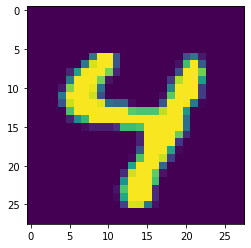

In [67]:
plt.imshow(pic.view(28,28))

In [68]:
# check size
print(pic.to(device)[None, :, :, :].shape)
print(pic.to(device).view(1, -1).shape)

torch.Size([1, 1, 28, 28])
torch.Size([1, 784])


### Encode

In [69]:
device = 'cpu'
mean_encoding, var_encoding = model.encode(pic.to(device).view(1, -1)) # note that we need to reshape the pic to be: bsx28*28 

# print encoding result
print('encoded mean: {}'.format(mean_encoding.detach().cpu().numpy()))
print('encoded  var: {}'.format(var_encoding.detach().cpu().numpy()))

encoded mean: [[-0.5592429   1.4444453   1.1667817  -0.18782139  1.0589974  -0.55701214
  -0.07533638  0.1629481   0.64944714  5.653008    0.3813714  -0.9495977
   1.085453   -1.5471504  -3.5718756   1.2370685  -0.7264838   0.53405297
   1.5231957  -1.6848253 ]]
encoded  var: [[-5.571127  -6.57798   -6.2529154 -5.8869295 -5.8825827 -5.62205
  -5.6434155 -6.084442  -6.771547  -5.3372474 -5.7165003 -6.550778
  -5.552048  -6.1818843 -5.855712  -5.3861585 -6.335955  -6.6406946
  -6.5768113 -6.869463 ]]


### Decode

In [70]:
decoding, _, _ = model.decode((mean_encoding, var_encoding))

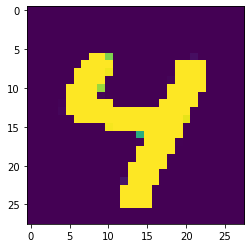

In [71]:
plt.imshow(decoding.cpu().data.view(28, 28))

## fin.